In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns # For plotting confusion matrix
import math

import argparse # Import argparse

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Paths
EPOCHS_DATA_PATH = "D:/capstone/LBM/processed_data_ica/all_epochs_ica_std.npy"
LABELS_PATH = "D:/capstone/LBM/processed_data_ica/all_labels_ica.npy"
T_MODEL_SAVE_PATH = 'D:/capstone/LBM/training/model_v7.pth'

# Hyperparameters
LATENT_DIM = 64
NUM_CLASSES = 3
BATCH_SIZE = 64
TEST_SPLIT_RATIO = 0.2
RANDOM_SEED = 42

# Transformer
T_NHEAD = 4
T_NUMLAYERS = 3
T_DIM_FEEDFORWARD = 128
T_DROPOUT = 0.2
T_LR = 1e-4
T_EPOCHS = 50

In [4]:
# # 2. VAE Model

# %%
class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Conv1d(128, latent_dim, kernel_size=1)
        self.fc_logvar = nn.Conv1d(128, latent_dim, kernel_size=1)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, 128, kernel_size=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, input_channels, kernel_size=4, stride=2, padding=1, output_padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, z.permute(0, 2, 1)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return z.permute(0, 2, 1)


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])

class EEGTransformerClassifier(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward, num_classes, dropout=0.1):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, input_dim))
        self.pos_encoder = PositionalEncoding(input_dim, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        cls = self.cls_token.expand(x.size(0), 1, -1)
        x = torch.cat((cls, x), dim=1)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.classifier(x[:, 0])


In [6]:
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class LatentSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


In [7]:
vae_losses = []
vae_recon_losses = []
vae_kl_losses = []
tf_train_losses = []
tf_val_losses = []
tf_train_accuracies = []
tf_val_accuracies = []


In [8]:
def train_vae(model, dataloader, optimizer, epochs, device):
    model.train()
    recon_criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        total_loss, total_recon, total_kl = 0, 0, 0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            recon, mu, logvar, _ = model(x)
            recon_loss = recon_criterion(recon, x)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + 0.001 * kl_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
        
        vae_losses.append(total_loss)
        vae_recon_losses.append(total_recon)
        vae_kl_losses.append(total_kl)
        print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Recon: {total_recon:.4f} | KL: {total_kl:.4f}")
    print("--- VAE Training Finished ---")


In [9]:
def encode_data_for_transformer(vae_model, dataloader, device):
    vae_model.eval()
    all_latents, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            z_seq = vae_model.encode(x)  # (B, T, D)
            all_latents.append(z_seq.cpu().numpy())
            all_labels.append(y.numpy())

    latent_data = np.concatenate(all_latents, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    print(f"Encoded shape: {latent_data.shape}")
    return latent_data, labels


In [10]:
def train_transformer(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss, all_preds, all_targets = 0, [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            all_targets.extend(y.cpu().numpy())

        train_acc = accuracy_score(all_targets, all_preds)
        tf_train_accuracies.append(train_acc)

        val_loss, val_acc = evaluate_transformer(model, val_loader, criterion, device)
        tf_val_accuracies.append(val_acc)

        tf_train_losses.append(total_loss / len(train_loader))
        tf_val_losses.append(val_loss)


        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving best model...")
            torch.save(model.state_dict(), T_MODEL_SAVE_PATH)


In [11]:
def evaluate_transformer(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
            all_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    return total_loss / len(loader), acc


In [12]:
# Load data
X = np.load(EPOCHS_DATA_PATH)
y = np.load(LABELS_PATH, allow_pickle=True)

# Label encode
unique_labels = sorted(set(y))
label_map = {label: i for i, label in enumerate(unique_labels)}
y_encoded = np.array([label_map[l] for l in y])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=TEST_SPLIT_RATIO, stratify=y_encoded, random_state=RANDOM_SEED)

# VAE 
vae = VAE(input_channels=X.shape[1], latent_dim=LATENT_DIM).to(device)
vae_optimizer = optim.Adam(vae.parameters(), lr=1e-4)
vae_loader = DataLoader(EEGDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

train_vae(vae, vae_loader, vae_optimizer, epochs=30, device=device)

# Encode latent vectors
latent_train, y_train_encoded = encode_data_for_transformer(vae, DataLoader(EEGDataset(X_train, y_train), batch_size=BATCH_SIZE), device)
latent_test, y_test_encoded = encode_data_for_transformer(vae, DataLoader(EEGDataset(X_test, y_test), batch_size=BATCH_SIZE), device)

# Transformer
transformer = EEGTransformerClassifier(input_dim=LATENT_DIM, nhead=T_NHEAD, num_layers=T_NUMLAYERS,
                                       dim_feedforward=T_DIM_FEEDFORWARD, num_classes=NUM_CLASSES,
                                       dropout=T_DROPOUT).to(device)
t_optimizer = optim.Adam(transformer.parameters(), lr=T_LR)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(LatentSequenceDataset(latent_train, y_train_encoded), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(LatentSequenceDataset(latent_test, y_test_encoded), batch_size=BATCH_SIZE, shuffle=False)

train_transformer(transformer, train_loader, val_loader, t_optimizer, criterion, T_EPOCHS, device)


Epoch 1 | Loss: 151.3848 | Recon: 151.0459 | KL: 338.9158
Epoch 2 | Loss: 77.8574 | Recon: 77.1115 | KL: 745.8578
Epoch 3 | Loss: 47.7316 | Recon: 46.7651 | KL: 966.5140
Epoch 4 | Loss: 43.7359 | Recon: 42.8037 | KL: 932.2165
Epoch 5 | Loss: 35.8846 | Recon: 34.9296 | KL: 955.0418
Epoch 6 | Loss: 30.3639 | Recon: 29.3969 | KL: 966.9681
Epoch 7 | Loss: 28.6317 | Recon: 27.6879 | KL: 943.8767
Epoch 8 | Loss: 27.9351 | Recon: 27.0207 | KL: 914.3919
Epoch 9 | Loss: 27.4573 | Recon: 26.5703 | KL: 886.9892
Epoch 10 | Loss: 26.8156 | Recon: 25.9484 | KL: 867.1794
Epoch 11 | Loss: 24.0736 | Recon: 23.2029 | KL: 870.6585
Epoch 12 | Loss: 22.6953 | Recon: 21.8361 | KL: 859.2357
Epoch 13 | Loss: 21.2735 | Recon: 20.4202 | KL: 853.2367
Epoch 14 | Loss: 20.5989 | Recon: 19.7575 | KL: 841.4079
Epoch 15 | Loss: 20.2110 | Recon: 19.3827 | KL: 828.3376
Epoch 16 | Loss: 19.9476 | Recon: 19.1331 | KL: 814.5710
Epoch 17 | Loss: 19.6391 | Recon: 18.8349 | KL: 804.1725
Epoch 18 | Loss: 18.6351 | Recon: 17.8

C:\Users\HYUN\AppData\Local\Temp\ipykernel_37884\2152543895.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(T_MODEL_SAVE_PATH, map

Accuracy: 0.6459826480573369
Classification Report:
               precision    recall  f1-score   support

       alert       0.70      0.88      0.78      2880
      drowsy       0.56      0.54      0.55      1090
  transition       0.47      0.23      0.31      1332

    accuracy                           0.65      5302
   macro avg       0.58      0.55      0.54      5302
weighted avg       0.61      0.65      0.61      5302



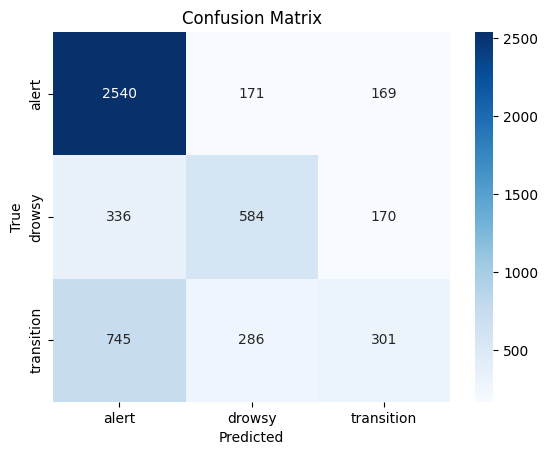

In [ ]:
# Load best transformer
transformer.load_state_dict(torch.load(T_MODEL_SAVE_PATH, map_location=device))

test_loader = DataLoader(LatentSequenceDataset(latent_test, y_test_encoded), batch_size=BATCH_SIZE, shuffle=False)

model_preds, model_targets = [], []
transformer.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = transformer(x)
        model_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
        model_targets.extend(y.numpy())

print("Accuracy:", accuracy_score(model_targets, model_preds))
print("Classification Report:\n", classification_report(model_targets, model_preds, target_names=unique_labels))

cm = confusion_matrix(model_targets, model_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

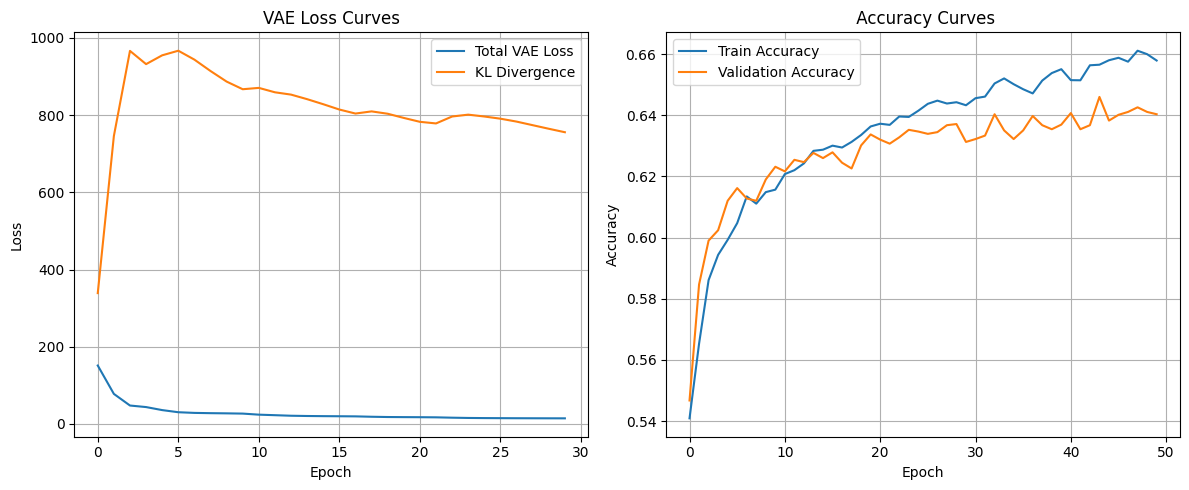

In [14]:
plt.figure(figsize=(12, 5))

# --- VAE Loss ---
plt.subplot(1, 2, 1)
plt.plot(vae_losses, label="Total VAE Loss")
plt.plot(vae_kl_losses, label="KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Loss Curves")
plt.legend()
plt.grid(True)

# --- Transformer Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(tf_train_accuracies, label="Train Accuracy")
plt.plot(tf_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(" Accuracy Curves")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


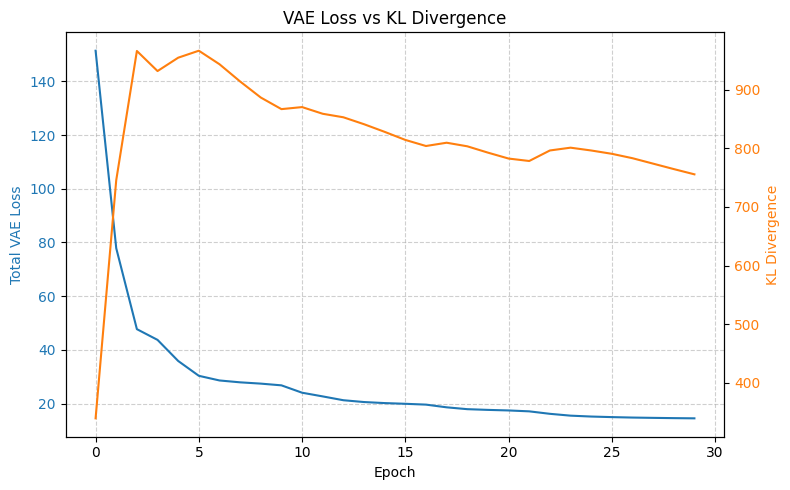

In [19]:
plt.figure(figsize=(8, 5))

# VAE Total Loss
ax1 = plt.gca()
ax1.plot(vae_losses, label="Total VAE Loss", color='tab:blue')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Total VAE Loss", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# KL Divergence
ax2 = ax1.twinx()
ax2.plot(vae_kl_losses, label="KL Divergence", color='tab:orange')
ax2.set_ylabel("KL Divergence", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title("VAE Loss vs KL Divergence")
ax1.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


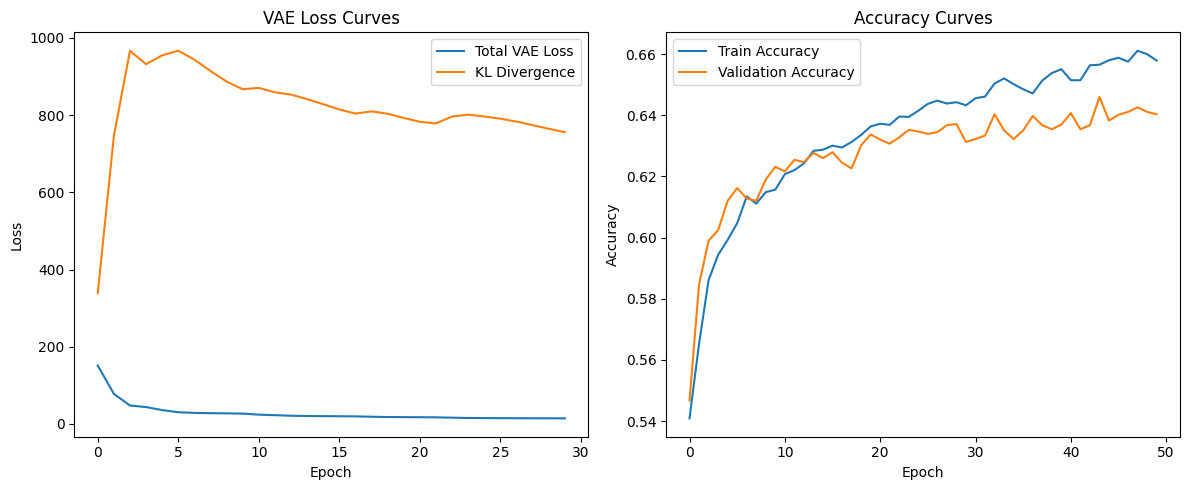

In [16]:
plt.figure(figsize=(12, 5))

# --- VAE Loss ---
plt.subplot(1, 2, 1)
plt.plot(vae_losses, label="Total VAE Loss")
plt.plot(vae_kl_losses, label="KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Loss Curves")
plt.legend()

# --- Transformer Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(tf_train_accuracies, label="Train Accuracy")
plt.plot(tf_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.tight_layout()
plt.show()


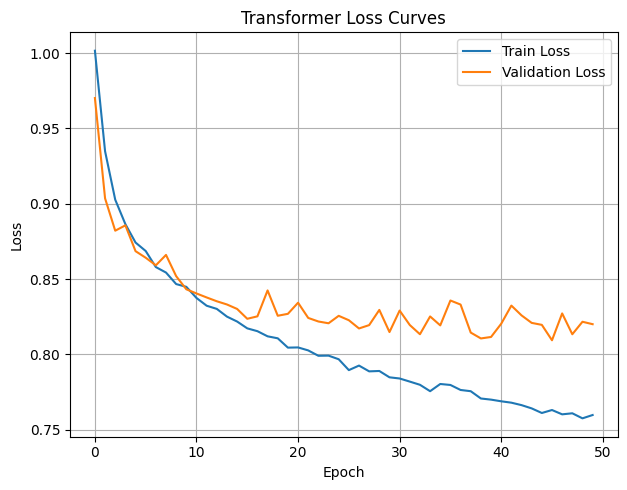

In [21]:
plt.figure(figsize=(12, 5))

# --- Transformer Loss ---
plt.subplot(1, 2, 1)
plt.plot(tf_train_losses, label="Train Loss")
plt.plot(tf_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transformer Loss Curves")
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from torch.nn.functional import softmax

# Convert predictions to soft probabilities
all_logits = []
transformer.eval()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        logits = transformer(x)
        all_logits.extend(logits.cpu().numpy())

all_logits = np.array(all_logits)
probs = softmax(torch.tensor(all_logits), dim=1).numpy()

# Metrics
mse = mean_squared_error(model_targets, model_preds)
mae = mean_absolute_error(model_targets, model_preds)
f1 = f1_score(model_targets, model_preds, average='weighted')
y_true_bin = label_binarize(model_targets, classes=list(range(NUM_CLASSES)))
roc_auc = roc_auc_score(y_true_bin, probs, average='weighted', multi_class='ovr')

print(f"MSE       : {mse:.4f}")
print(f"MAE       : {mae:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")


MSE       : 0.8712
MAE       : 0.5264
F1-score  : 0.6138
ROC-AUC   : 0.7972
